In [67]:
from pypdf import PdfReader
import itertools
import numpy as np
import random
import lzma
import deflate
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
folder = "documents"
ukr_texts = ["Конституція.pdf", "Енеїда.pdf", "Кучма.pdf", "Хто.pdf", "Bondar_bakalavr.pdf", "Kistaiev_bakalavr.pdf"]

large_text = ""

for text in ukr_texts:
    reader = PdfReader(f"{folder}/{text}")
    for page in reader.pages:
        large_text += page.extract_text() + "\n"


In [4]:
alph_full = list('АаБбВвГгҐґДдЕеЄєЖжЗзИиІіЇїЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЬьЮюЯя')
alph_1 = list(' абвгґдеєжзиіїйклмнопрстуфхцчшщьюя')
alph_2 = [f'{c1}{c2}' for c1, c2 in itertools.product(alph_1, alph_1)]
lang = []

for c in large_text:
    if c in alph_full:
        lang.append(str.lower(c))
    elif lang[-1] != ' ':
        lang.append(' ')

alph = [' '] + alph_full
lang = "".join(lang)

ARING1 = dict(zip(list(alph_1), range(len(alph_1))))
ARING2 = dict(zip(list(alph_2), range(len(alph_2))))

In [5]:
n = len(lang)

lang_1_shreq = dict(zip(alph_1, [0]*len(alph_1)))
for c in lang:
    lang_1_shreq[c] += 1

lang_1_shreq = {key: val / (n - 1) for key, val in lang_1_shreq.items()}


lang_2_shreq = dict(zip(alph_2, [0]*len(alph_2)))
for c1, c2 in zip(lang[:-1], lang[1:]):
    lang_2_shreq[f'{c1}{c2}'] += 1

lang_2_shreq = {key: val / (n - 1) for key, val in lang_2_shreq.items()}

print(n)
print(lang_1_shreq)
print(lang_2_shreq)

2225382
{' ': 0.15635974244410283, 'а': 0.06886146686792059, 'б': 0.014084329829364051, 'в': 0.04702655410466792, 'г': 0.013156848198128769, 'ґ': 3.055656537015459e-05, 'д': 0.027879271010222518, 'е': 0.03994866497017814, 'є': 0.003587250902205061, 'ж': 0.007517813803568917, 'з': 0.01869387758770296, 'и': 0.05343489496854696, 'і': 0.04630173439963763, 'ї': 0.007580275018075557, 'й': 0.010577514591883367, 'к': 0.032522071501464245, 'л': 0.031105235463051047, 'м': 0.025339930555711584, 'н': 0.05820801022386728, 'о': 0.08053497356183054, 'п': 0.023567649764242617, 'р': 0.040964221407480336, 'с': 0.03807977150878883, 'т': 0.04143200647439697, 'у': 0.03007440074306377, 'ф': 0.0022328760782985026, 'х': 0.009462649317128168, 'ц': 0.0072585323591780465, 'ч': 0.010776132266789373, 'ш': 0.006870284234474906, 'щ': 0.004235229832554515, 'ь': 0.0156588916684379, 'ю': 0.0071695588306002435, 'я': 0.019467228308321136}
{'  ': 0.0, ' а': 0.003484796535963954, ' б': 0.0060928892625577375, ' в': 0.014814

In [6]:
def vigenere_encrypt(ptext: str, key: str):
    r = int(np.ceil(len(ptext) / len(key)))

    ntxt = np.array([ARING1[c] for c in ptext])
    nkey = np.array([ARING1[c] for c in key] * r)

    return "".join([alph_1[c] for c in (ntxt + nkey) % len(alph_1)])


def vigenere_decrypt(ctext: str, key: str):
    r = int(np.ceil(len(ctext) / len(key)))

    ntxt = np.array([ARING1[c] for c in ctext])
    nkey = np.array([ARING1[c] for c in key] * r)

    return "".join([alph_1[c] for c in (ntxt - nkey) % len(alph_1)])


def affine_ecrypt(text: str, a: int, b: int):
    if np.gcd(a, len(alph_1)) != 1:
        raise RuntimeError("Incorrect key, gcd(a, n) != 1")
    
    res = ""
    for i in range(0, len(text)):
        id = (a * ARING1[text[i]] + b) % len(alph_1)
        res += alph_1[id]

    return res


def affine_bigram_ecrypt(text: str, a: int, b: int):
    if np.gcd(a, len(alph_2)) != 1:
        raise RuntimeError("Incorrect key, gcd(a, n) != 1")
    
    res = ""

    for c1, c2 in zip(text[:-1], text[1:]):
        id = (a * ARING2[f'{c1}{c2}'] + b) % len(alph_2)
        res += alph_2[id]

    return res

In [ ]:
def generate_random_text(length):
    return ''.join(random.SystemRandom().choice(alph_1) for _ in range(length))


def generate_recur(length):
    res = ''
    res += random.SystemRandom().choice(alph_1)
    res += random.SystemRandom().choice(alph_1)
    for _ in range(0, length - 1):
        res += alph_1[(ARING1[res[-1]] + ARING1[res[-2]]) % len(alph_1)]
    return res


def generate_rand_lang_text(length):
    i = random.randrange(0, len(lang) - length)

    return "".join(lang[i:i+length])


In [8]:
def gram_1_shreqs(A, text):
    text_1_shreqs = dict(zip(A, [0]*len(A)))

    for c in text:
        if c in A:
            text_1_shreqs[c] += 1 
    
    return {key: val / (len(text) - 1) for key, val in text_1_shreqs.items()}

def gram_2_shreqs(A, text):
    text_2_shreqs = dict(zip(A, [0]*len(A)))

    for c1, c2 in zip(text[:-1], text[1:]):
        if f'{c1}{c2}' in A:
            text_2_shreqs[f'{c1}{c2}'] += 1 

    return {key: val / (len(text) - 1) for key, val in text_2_shreqs.items()}



def index_of_coincidence(l_gram_counts):
    counts = np.array(list(l_gram_counts.values()))
    N = counts.sum()
    I = sum(count * (count - 1) for count in counts) / (N * (N - 1))

    return I


def avg_entropy(text, l):
    l_gram_shreqs = defaultdict(lambda: 0)

    for i in range(len(text) - l):
        l_gram_shreqs[text[i:i+l]] += 1

    probs = np.array(list(l_gram_shreqs.values())) / (len(text) - l + 1)
    H = -probs.dot(np.log2(probs)) / l

    return H


def n_empty_1_boxes(B_freq, text):
    return sum(np.array(list(gram_1_shreqs(B_freq, text).values())) == 0)

def n_empty_2_boxes(B_freq, text):
    return sum(np.array(list(gram_2_shreqs(B_freq, text).values())) == 0)


def lzma_compression_ratio(text):
    txt = text.encode()
    original_len = len(txt)

    ctxt = lzma.compress(txt)
    compressed_len = len(ctxt)

    return compressed_len / original_len


def deflate_compression_ratio(text):
    txt = text.encode()
    original_len = len(txt)

    ctxt = deflate.gzip_compress(txt, 12)
    compressed_len = len(ctxt)

    return compressed_len / original_len

{'ґ': 3.055656537015459e-05, 'ф': 0.0022328760782985026, 'є': 0.003587250902205061, 'щ': 0.004235229832554515, 'ш': 0.006870284234474906, 'ю': 0.0071695588306002435, 'ц': 0.0072585323591780465, 'ж': 0.007517813803568917, 'ї': 0.007580275018075557, 'х': 0.009462649317128168, 'й': 0.010577514591883367, 'ч': 0.010776132266789373, 'г': 0.013156848198128769, 'б': 0.014084329829364051, 'ь': 0.0156588916684379}
{'  ': 0.0, 'аь': 0.0, 'бї': 0.0, 'бй': 0.0, 'вґ': 0.0, 'вї': 0.0, 'гб': 0.0, 'гг': 0.0, 'гґ': 0.0, 'гє': 0.0, 'гж': 0.0, 'гї': 0.0, 'гй': 0.0, 'гф': 0.0, 'гх': 0.0, 'гц': 0.0, 'гщ': 0.0, 'гю': 0.0, 'ґ ': 0.0, 'ґб': 0.0, 'ґг': 0.0, 'ґґ': 0.0, 'ґд': 0.0, 'ґє': 0.0, 'ґж': 0.0, 'ґз': 0.0, 'ґи': 0.0, 'ґї': 0.0, 'ґй': 0.0, 'ґк': 0.0, 'ґл': 0.0, 'ґм': 0.0, 'ґп': 0.0, 'ґс': 0.0, 'ґт': 0.0, 'ґф': 0.0, 'ґх': 0.0, 'ґц': 0.0, 'ґч': 0.0, 'ґш': 0.0, 'ґщ': 0.0, 'ґь': 0.0, 'ґю': 0.0, 'ґя': 0.0, 'дї': 0.0, 'дф': 0.0, 'еґ': 0.0, 'еь': 0.0, 'єа': 0.0, 'єб': 0.0, 'єґ': 0.0, 'єе': 0.0, 'єи': 0.0, 'єо': 0.

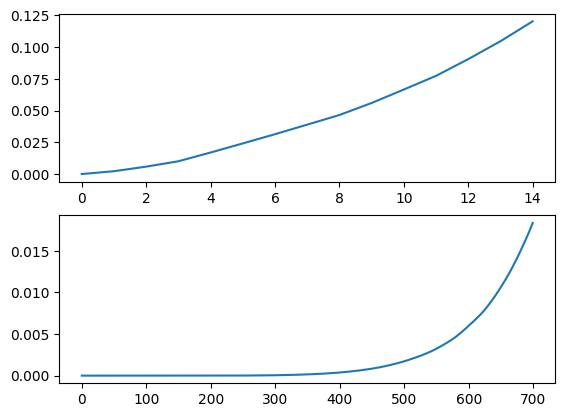

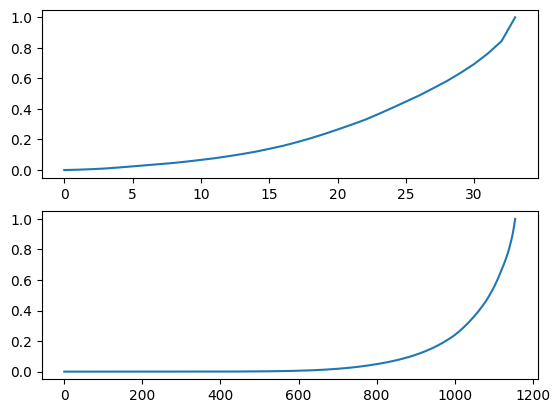

In [9]:
A1_prh = {k: v for k, v in sorted(lang_1_shreq.items(), key=lambda item: item[1])[0:15]}
print(A1_prh)

A2_prh = {k: v for k, v in sorted(lang_2_shreq.items(), key=lambda item: item[1])[0:700]}
print(A2_prh)

fig, axs1 = plt.subplots(2, 1)
axs1[0].plot(range(len(A1_prh.keys())), np.cumsum(list(A1_prh.values())))
axs1[1].plot(range(len(A2_prh.keys())), np.cumsum(list(A2_prh.values())))

A1_prh = list(A1_prh.keys())[0:9]
A2_prh = list(A2_prh.keys())[0:450]


B1_freq = {k: v for k, v in sorted(lang_1_shreq.items(), key=lambda item: item[1])[:]}
print(B1_freq)

B2_freq = {k: v for k, v in sorted(lang_2_shreq.items(), key=lambda item: item[1])[:]}
print(B2_freq)

fig, axs2 = plt.subplots(2, 1)
axs2[0].plot(range(len(B1_freq.keys())), np.cumsum(list(B1_freq.values())))
axs2[1].plot(range(len(B2_freq.keys())), np.cumsum(list(B2_freq.values())))

B1_freq = list(B1_freq.keys())[14:]
B2_freq = list(B2_freq.keys())[850:]


lang_1_entropy = avg_entropy("".join(lang), 1)
lang_2_entropy = avg_entropy("".join(lang), 2)


In [23]:
def crit_10_stat(text, l):
    if l == 1:
        return max(np.array(gram_1_shreqs(A1_prh, text).values()))
    elif l == 2:
        return max(np.array(gram_2_shreqs(A2_prh, text).values()))

def crit_11_stat(text, l):
    if l == 1:
        return sum(np.array(list(gram_1_shreqs(A1_prh, text).values())) > 0)
    elif l == 2:
        return sum(np.array(list(gram_2_shreqs(A2_prh, text).values())) > 0)

def crit_12_stat(text, l):
    if l == 1:
        return max(np.array(list(gram_1_shreqs(A1_prh, text).values())))
    elif l == 2:
        return max(np.array(list(gram_2_shreqs(A2_prh, text).values())))
    
def crit_13_stat(text, l):
    if l == 1:
        return sum(list(gram_1_shreqs(A1_prh, text).values()))
    elif l == 2:
        return sum(list(gram_2_shreqs(A2_prh, text).values()))
    
def crit_30_stat(text, l):
    if l == 1:
        return lang_1_entropy - avg_entropy(text, 1)
    elif l == 2:
        return lang_2_entropy - avg_entropy(text, 2)
    
def crit_51_stat(text, l):
    if l == 1:
        return n_empty_1_boxes(B1_freq, text)
    elif l == 2:
        return n_empty_2_boxes(B2_freq, text)

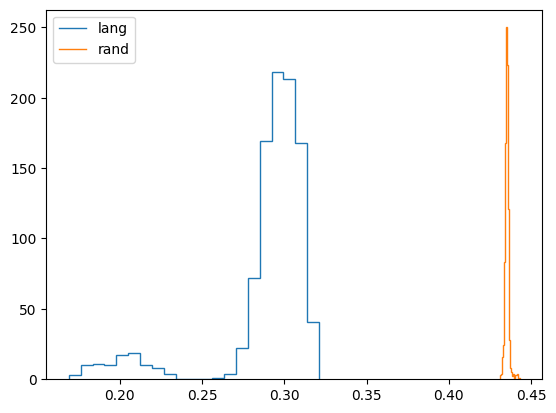

In [ ]:
def plot_stat_distr(crit_stat_f, text_len, n_texts):
    lang_stat = []
    rand_stat = []

    for i in range(n_texts):
        lang_text = generate_rand_lang_text(text_len)
        rand_text = generate_random_text(text_len)

        lang_stat.append(crit_stat_f(lang_text))
        rand_stat.append(crit_stat_f(rand_text))

    ax = plt.subplot()

    counts1, bins1 = np.histogram(lang_stat, int(np.ceil(3*np.log(n_texts))))
    ax.stairs(counts1, bins1)

    counts2, bins2 = np.histogram(rand_stat, int(np.ceil(3*np.log(n_texts))))
    ax.stairs(counts2, bins2)

    ax.legend(["lang", "rand"])


n = 10000
S = int(50*np.ceil(0.2*np.sqrt(n)))

plot_stat_distr(lambda text: deflate_compression_ratio(text), n, S)


k10_1 = {10: 0, 100: 0, 1000: 0, 10000: 0}
k10_2 = {10: 0, 100: 0, 1000: 0, 10000: 0}

k11_1 = {10: 1.5, 100: 6.5, 1000: 8.85, 10000: 8.99}
k11_2 = {10: 0.25, 100: 14, 1000: 144, 10000: 225}

k12_1 = {10: 0.675, 100: 0.035, 1000: 0.0285, 10000: 0.0285}
k12_2 = {10: 0.06, 100: 0.01, 1000: 0.00315, 10000: 0.0013}

k13_1 = {10: 0.16, 100: 0.14, 1000: 0.15, 10000: 0.16}
k13_2 = {10: 0.075, 100: 0.21, 1000: 0.21, 10000: 0.21}

k30_1 = {10: 1.715, 100: -0.05, 1000: -0.3, 10000: -0.3}
k30_2 = {10: 2.67, 100: 0.875, 1000: -0.18, 10000: -0.45}

k51_1 = {10: 13.5, 100: 1.9, 1000: 0.1, 10000: 0.1}
k51_2 = {10: 300.4, 100: 264, 1000: 108, 10000: 1.25}

ks = {10: 2.125, 100: 0.75, 1000: 0.475, 10000: 0.38}

In [ ]:
def plot_stat_distr(crit_stat_f, crit_val, text_len, n_texts):
    lang_stat = []
    rand_stat = []

    for i in range(n_texts):
        lang_text = generate_rand_lang_text(text_len)
        rand_text = generate_random_text(text_len)

        lang_stat.append(crit_stat_f(lang_text))
        rand_stat.append(crit_stat_f(rand_text))

